# MNIST PCA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten images and normalize
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1) / 255.0

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM without PCA
print("Training SVM without PCA...")
start_time = time.time()
svm_params = {'C': [0.1, 1, 10]}
svm = GridSearchCV(SVC(kernel='rbf'), svm_params, cv=3, verbose=1, n_jobs=-1)
svm.fit(X_train[:5000], y_train[:5000]) # Using subset for speed

best_C = svm.best_params_['C']
final_svm = SVC(kernel='rbf', C=best_C)
final_svm.fit(X_train, y_train)
y_pred = final_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy without PCA: {accuracy:.4f}")
end_time = time.time()
print(f"Training and Inference Time without PCA: {end_time - start_time} seconds")

# Apply PCA and find the best n_components
pca = PCA(n_components=0.95) # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of components retained by PCA: {pca.n_components_}")

# Train SVM with PCA
print("\nTraining SVM with PCA...")
start_time = time.time()
svm_pca_params = {'C': [0.1, 1, 10]}
svm_pca = GridSearchCV(SVC(kernel='rbf'), svm_pca_params, cv=3, verbose=1, n_jobs=-1)
svm_pca.fit(X_train_pca[:5000], y_train[:5000]) # Using subset for speed

best_C_pca = svm_pca.best_params_['C']
final_svm_pca = SVC(kernel='rbf', C=best_C_pca)
final_svm_pca.fit(X_train_pca, y_train)
y_pred_pca = final_svm_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"SVM Accuracy with PCA: {accuracy_pca:.4f}")
end_time = time.time()
print(f"Training and Inference Time with PCA: {end_time - start_time} seconds")

# Compare performance
print("\nPerformance Comparison:")
print(f"Accuracy without PCA: {accuracy:.4f}")
print(f"Accuracy with PCA: {accuracy_pca:.4f}")


4422102/4422102 [==============================] - 1s 0us/step
Training SVM without PCA...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Accuracy without PCA: 0.8986
Training and Inference Time without PCA: 482.4149069786072 seconds
Number of components retained by PCA: 256

Training SVM with PCA...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVM Accuracy with PCA: 0.8995
Training and Inference Time with PCA: 204.259868144989 seconds

Performance Comparison:
Accuracy without PCA: 0.8986
Accuracy with PCA: 0.8995


# M1 Feature Engineering 

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.decomposition import PCA

# Load the dataset
data = pd.read_csv("train.csv")

# Separate numeric and non-numeric columns
numeric_cols = data.select_dtypes(include=np.number).columns
non_numeric_cols = data.select_dtypes(exclude=np.number).columns

# Handle missing values for numeric columns
imputer_numeric = SimpleImputer(strategy='mean')
data[numeric_cols] = imputer_numeric.fit_transform(data[numeric_cols])

# Feature Engineering

# 1. One-Hot Encoding for categorical features
if 'day' in data.columns:
    encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    day_encoded = encoder.fit_transform(data[['day']])
    day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['day']))
    data = pd.concat([data.drop(columns=['day']), day_encoded_df], axis=1)

# 2. Interaction Features
if 'C_motion' in data.columns and 'feed_water_motion' in data.columns:
    data['C_motion_x_feed_water_motion'] = data['C_motion'] * data['feed_water_motion']

# Define target and features
X = data.drop(columns=['output_electricity_generation'])
y = data['output_electricity_generation']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Baseline Model without Feature Selection
print("\nBaseline Model:")
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Feature Selection Methods

# 1. Variance Thresholding
print("\nVariance Thresholding:")
vt_selector = VarianceThreshold(threshold=0.1)
X_train_vt = vt_selector.fit_transform(X_train)
X_test_vt = vt_selector.transform(X_test)

model_vt = RandomForestRegressor(random_state=42)
model_vt.fit(X_train_vt, y_train)
y_pred_vt = model_vt.predict(X_test_vt)
vt_rmse = np.sqrt(mean_squared_error(y_test, y_pred_vt))
print(f"VarianceThreshold RMSE: {vt_rmse:.4f}")

# 2. Univariate Feature Selection: SelectKBest with F-statistic
print("\nUnivariate Feature Selection - SelectKBest:")
kbest_selector = SelectKBest(score_func=f_regression, k=10)
X_train_kbest = kbest_selector.fit_transform(X_train, y_train)
X_test_kbest = kbest_selector.transform(X_test)

model_kbest = RandomForestRegressor(random_state=42)
model_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = model_kbest.predict(X_test_kbest)
kbest_rmse = np.sqrt(mean_squared_error(y_test, y_pred_kbest))
print(f"SelectKBest RMSE: {kbest_rmse:.4f}")

# 3. PCA for Dimensionality Reduction
print("\nPCA:")
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_pca = RandomForestRegressor(random_state=42)
model_pca.fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)
pca_rmse = np.sqrt(mean_squared_error(y_test, y_pred_pca))
print(f"PCA RMSE: {pca_rmse:.4f}")

# Compare Results
print("\nComparison of RMSE:")
print(f"Baseline Model RMSE: {baseline_rmse:.4f}")
print(f"VarianceThreshold RMSE: {vt_rmse:.4f}")
print(f"SelectKBest RMSE: {kbest_rmse:.4f}")
print(f"PCA RMSE: {pca_rmse:.4f}")



Baseline Model:
Baseline RMSE: 3.2163

Variance Thresholding:
VarianceThreshold RMSE: 3.2163

Univariate Feature Selection - SelectKBest:
SelectKBest RMSE: 3.3597

PCA:
PCA RMSE: 11.9530

Comparison of RMSE:
Baseline Model RMSE: 3.2163
VarianceThreshold RMSE: 3.2163
SelectKBest RMSE: 3.3597
PCA RMSE: 11.9530


# Iris Dataset K-Means

c:\Users\Suraj Mehta\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Suraj Mehta\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score: 0.4599


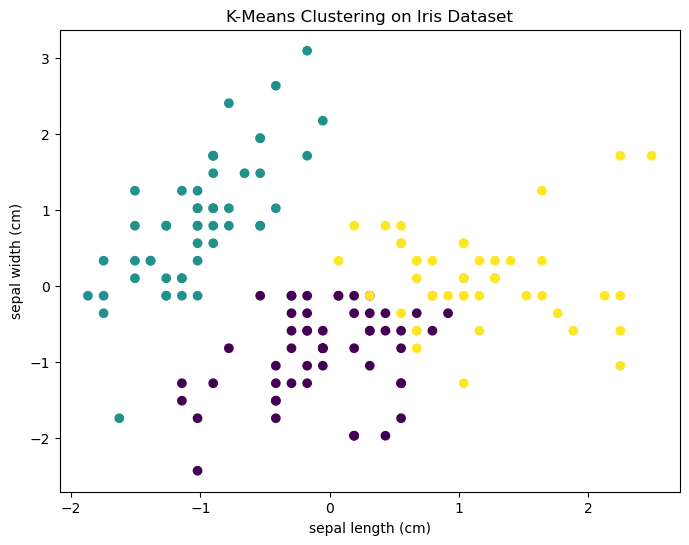

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)

# Predict cluster labels
labels = kmeans.labels_

# Evaluate clustering using silhouette score
silhouette = silhouette_score(X_scaled, labels)
print(f"Silhouette Score: {silhouette:.4f}")

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.title("K-Means Clustering on Iris Dataset")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.show()